# Sarcasm Clasiffier

In [1]:
import os 
from pathlib import Path
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.functional as taF
from torch.utils.data import Dataset, random_split, DataLoader
import torchaudio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Audio

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
class SarcasmDataset(Dataset):
    
    def __init__(self, file_path: str):
        self.file_path=file_path 
        
        walker = sorted(str(p) for p in Path(self.file_path).glob(f'*/*'))
        self.walker = list(walker)
        
    def __getitem__(self, n: int) -> Tuple[torch.Tensor, str]:
        fileid = self.walker[n]
        label= self.walker[n].split('/')[-2]
        
        relpath = os.path.relpath(fileid, self.file_path)
        label, filename = os.path.split(relpath)
        waveform, sample_rate = torchaudio.load(fileid)
        waveform_mono = torch.mean(waveform, dim=0, keepdim=True)
        seg_duration = len(waveform_mono[0])/sample_rate #expresed in seconds
        
        return waveform_mono, sample_rate, label, seg_duration, fileid
    
    def __len__(self) -> int:
        return len(self.walker)

In [4]:
data=SarcasmDataset('../Audios/mp3')

## Audio graphics
Representación gráfica con tiempo y amplitud.

Normal
tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0003,  0.0015,  0.0029]])


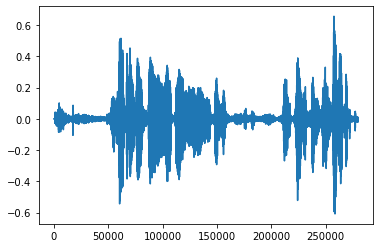

Shape of spectrogram: torch.Size([1, 201, 1400])


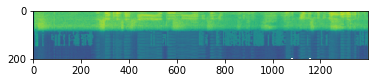

Sarcasmo
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0028, 0.0019, 0.0018]])


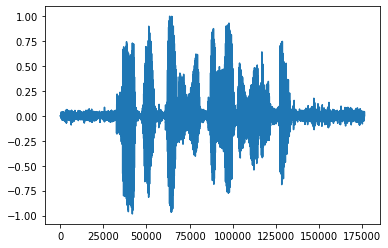

Shape of spectrogram: torch.Size([1, 201, 882])


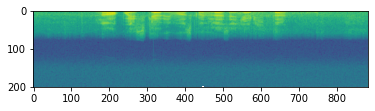

In [5]:
for i in [0,len(data)-1]:
    (waveform_mono, sample_rate, label, seg_duration, fileid) = data[i]
    print(label)
    print(waveform_mono)
    # Waveform graph
    plt.plot(waveform_mono[0])
    plt.show()
    # Spectrogram
    specgram = torchaudio.transforms.Spectrogram()(waveform_mono)
    print('Shape of spectrogram:', specgram.size())
    plt.figure()
    plt.imshow(specgram.log2()[0, :, :].numpy())
    plt.show()

## Data quality

In [6]:
d = {"waveform_mono":[], "sample_rate":[], "label":[], "seg_duration":[], "fileid":[]}

for i in range(len(data)):
    datos = data[i]
    d["waveform_mono"].append(datos[0].numpy())
    d["sample_rate"].append(datos[1])
    d["label"].append(datos[2])
    d["seg_duration"].append(datos[3])
    d["fileid"].append(datos[4])

In [7]:
table_data = pd.DataFrame.from_dict(d)

In [8]:
table_data.head(2)

waveform_mono  sample_rate   label  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        44100  Normal   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        44100  Normal   

   seg_duration                             fileid  
0      6.347755   ../Audios/mp3/Normal/Audio_1.mp3  
1     12.747755  ../Audios/mp3/Normal/Audio_10.mp3

In [9]:
table_data.describe()

sample_rate  seg_duration
count    207.000000    207.000000
mean   46869.565217      5.487632
std     1773.699798      3.816620
min    44100.000000      1.149388
25%    44100.000000      3.169325
50%    48000.000000      4.557833
75%    48000.000000      6.347755
max    48000.000000     31.164082

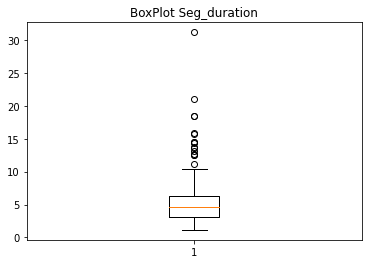

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('BoxPlot Seg_duration')
ax1.boxplot(table_data["seg_duration"])
plt.show()

In [11]:
table_data[table_data["seg_duration"]>30]

waveform_mono  sample_rate     label  \
175  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        44100  Sarcasmo   

     seg_duration                               fileid  
175     31.164082  ../Audios/mp3/Sarcasmo/Audio_70.mp3

In [12]:
display(Audio(table_data[table_data["seg_duration"]>30]["fileid"].values[0]))

We delete this atypical sample and save it in a new data frame.

In [13]:
table_data.shape

(207, 5)

In [14]:
table_data1 = table_data.drop([175],axis=0)
table_data1.shape

(206, 5)

Now we relabel the rows of the new table and check the data without the deleted sample.

In [15]:
table_data1.reset_index(drop=True, inplace=True)

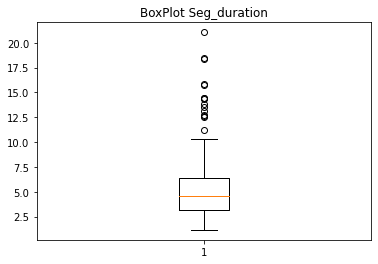

In [16]:
fig1, ax1 = plt.subplots()
ax1.set_title('BoxPlot Seg_duration')
ax1.boxplot(table_data1["seg_duration"])
plt.show()

In [17]:
table_data1.describe()

sample_rate  seg_duration
count    206.000000    206.000000
mean   46883.009709      5.362989
std     1767.415826      3.377282
min    44100.000000      1.149388
25%    44100.000000      3.165071
50%    48000.000000      4.547833
75%    48000.000000      6.347755
max    48000.000000     21.057833

## Normalization

In [18]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

We'll see the effect of the normalization in the first audio.

In [19]:
table_data1.iloc[0][0]

array([[ 0.        ,  0.        ,  0.        , ..., -0.00028628,
         0.0014984 ,  0.00294179]], dtype=float32)

In [20]:
display(Audio(table_data1.iloc[0]["fileid"]))

Now we apply the normalization.

In [21]:
# Let's normalize to the full interval [-1,1]
for row in range(0,table_data1.shape[0]):
    audio_tensor = torch.from_numpy(table_data1.at[row,"waveform_mono"])
    waveform_norm = normalize(audio_tensor)
    table_data1.at[row,"waveform_mono"] = waveform_norm.numpy()

We save momentarily the audio to see the change in the waveform and in the audio.

In [22]:
#if we want to save an audio
(waveform_mono, sample_rate, label, seg_duration, fileid) = table_data1.iloc[0]
torchaudio.save('../Audios/borrador/borrador.wav', torch.from_numpy(waveform_mono), sample_rate)

In [23]:
waveform_mono, sample_rate = torchaudio.load("../Audios/borrador/borrador.wav")
print(waveform_mono)
print(sample_rate)

tensor([[ 5.0068e-05,  5.0068e-05,  5.0068e-05,  ..., -3.8582e-04,
          2.3315e-03,  4.5291e-03]])
44100


In [24]:
display(Audio("../Audios/borrador/borrador.wav"))

## Reshape sample rates

We pick the maximum sample rate. We'll see the effect of the normalization in the audio with minimum seg_duration.

In [25]:
index_min = np.where(table_data1["seg_duration"]==table_data1["seg_duration"].min())[0][0]
min_len=data[index_min][0].size()[1]
min_len

50688

In [26]:
display(Audio(table_data1.iloc[index_min]["fileid"]))

In [27]:
#table_data2 = table_data1.copy(deep=True) used for test

In [28]:
int(table_data1["sample_rate"].max())

48000

In [29]:
# same sample rate for all audios
resample_rate = 48000

for row in range(0,table_data1.shape[0]):
    (waveform_mono, sample_rate, label, seg_duration, fileid) = table_data1.iloc[row]
    resampled_waveform = taF.resample(torch.from_numpy(waveform_mono), sample_rate, resample_rate, rolloff=0.99) #waveform_mono, sample_rate
    table_data1.at[row,"waveform_mono"] = resampled_waveform.numpy()
    
table_data1["sample_rate"] = resample_rate

In [30]:
#if we want to save an audio
(waveform_mono, sample_rate, label, seg_duration, fileid) = table_data1.iloc[index_min]
torchaudio.save('../Audios/borrador/borrador.wav', torch.from_numpy(waveform_mono), sample_rate)

In [31]:
waveform_mono, sample_rate = torchaudio.load("../Audios/borrador/borrador.wav")
print(waveform_mono)
print(sample_rate)

tensor([[-1.3411e-05, -1.3828e-05, -1.3173e-05,  ...,  4.7213e-04,
          2.6292e-04,  6.6578e-05]])
48000


In [32]:
display(Audio("../Audios/borrador/borrador.wav"))

## Padding

We'll do the padding in the audios, so they'll have the same lenght as the audio with maximum seg_duration.

In [33]:
#table_data3 = table_data2.copy(deep=True) used for test

In [34]:
index_max = np.where(table_data1["seg_duration"]==table_data1["seg_duration"].max())[0][0]
max_len= table_data1.iloc[index_max][0].size
max_len

1010776

In [35]:
display(Audio(table_data1.iloc[index_max]["fileid"]))

We'll see the effect of the padding in the audio with minimum seg_duration.

In [37]:
display(Audio("../Audios/borrador/borrador.wav"))

In [38]:
for row in range(0,table_data1.shape[0]):
    (waveform_mono, sample_rate, label, seg_duration, fileid) = table_data1.iloc[row]
    waveform_pad=torch.from_numpy(waveform_mono)
    audio_len=waveform_pad[0].shape[0]
    target_size=(max_len-audio_len)/2
    #print(target_size)
    if np.floor(target_size) == target_size:
        target_size = int(target_size)
        p1d = (target_size, target_size) # pad last dim by 1 on each side
    else:
        target_size = int(target_size)
        p1d = (target_size, target_size+1)
    out = F.pad(waveform_pad, p1d, "constant", 0)  # effectively zero padding
    #print(out.size())
    table_data1.at[row,"waveform_mono"] = out.numpy()
    
table_data1["seg_duration"] = table_data1["seg_duration"].max()

We save it for listen it with the padding.

In [39]:
#if we want to save an audio
(waveform_mono, sample_rate, label, seg_duration, fileid) = table_data1.iloc[index_min]
torchaudio.save('../Audios/borrador/borrador_pad.wav', torch.from_numpy(waveform_mono), sample_rate)

In [40]:
waveform_mono, sample_rate = torchaudio.load("../Audios/borrador/borrador_pad.wav")
print(waveform_mono)
print(sample_rate)

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
48000


In [41]:
display(Audio("../Audios/borrador/borrador_pad.wav"))

Now we can save the table with data preprocessing able to be used in the model.

In [47]:
table_data1.to_csv("../Data_clean.csv", index_label=False)

## Charge clean data for model

In [55]:
table_data1=pd.read_csv("../Data_clean.csv")
len(table_data1)

206

In [57]:
train_len=int(len(table_data1)*0.8)
val_len=int(len(table_data1)*0.2)

train_set, val_set=random_split(table_data1, [train_len, val_len+1])

In [59]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

train_loader = DataLoader(train_set, batch_size=16, shuffle = True, **kwargs)
val_loader = DataLoader(val_set,shuffle = True, **kwargs)

### First model

In [95]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden1= nn.Linear(1010776, 524288) # 2**19 = 524288
        self.drop = nn.Dropout(0.5)
        self.hidden2= nn.Linear(524288, 4096) # 2**12 = 4096
        self.out = nn.Linear(4096, 256) # 2**8 = 256
        self.actRelu = nn.ReLU()
        self.actSig = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(self(x)) # [batch_size, 1010776]
        x = self.actRelu(x)
        x = self.drop(x)
        x = self.hidden2(x)
        x = self.actRelu(x)
        x = self.drop(x)
        #x = x.view(x.size(0), -1)
        x = self.out(x)
        x = self.actSig(x)
        return x

model = NeuralNet()

RuntimeError: [enforce fail at CPUAllocator.cpp:68] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 2119750909952 bytes. Error code 12 (Cannot allocate memory)